In [2]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [58]:

import pandas_datareader as pdr
import pandas as pd 
key = '1e9dd563cc22287463f26ece575a87e2ea974ce6'
#import external pandas_datareader library with alias of web
import pandas_datareader as web
import datetime


#Defining time frame  

start = datetime.datetime(2005, 9, 1)
end = datetime.datetime(2020, 6, 18)

#DataReader allows to download data from yahoo

#### DAX 30 Index #### CLOSE x in csv file
df_dax30 = web.DataReader("^GDAXI",'yahoo', start, end)
df_dax30_close = df_dax30['Close']
df_dax30_close.to_csv('DAX30_close.csv')

#### VIX Index #### CLOSE y in csv file
df_vix = web.DataReader("^VIX",'yahoo', start, end)
df_vix_close = df_vix['Close']
df_vix_close.to_csv('VIX_Close.csv')

#### TED spread ####
c = pd.read_csv('TEDRATE.csv')
c.rename(columns={'DATE': 'Date'})

,Date,TEDRATE
0,1986-01-02,0.90
1,1986-01-03,0.99
2,1986-01-06,1.07
3,1986-01-07,1.09
4,1986-01-08,0.83
...,...,...
8982,2020-06-08,0.14
8983,2020-06-09,0.12
8984,2020-06-10,0.15
8985,2020-06-11,0.14


In [59]:
a = pd.read_csv('DAX30_close.csv')
b = pd.read_csv('VIX_Close.csv')

merged = a.merge(b, on='Date') #aligns data on date 
merged.to_csv("data_lstm.csv", index=False)

In [60]:
# adding ted spread to dataset 

c = pd.read_csv('data_lstm.csv')
d = pd.read_csv('TEDRATE.csv')

header_tedrate = ['Date', 'TEDRATE']
d = pd.read_csv('TEDRATE.csv', header=None, skiprows=1, names = header_tedrate)

merged = c.merge(d, on='Date') #aligns data on date 
merged.to_csv("data_lstm.csv", index=False)


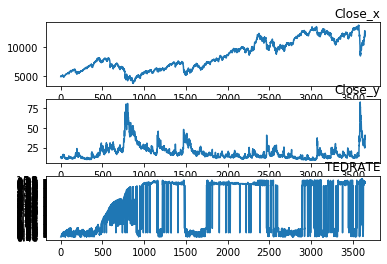

In [64]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('data_lstm.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=1, loc='right')
	i += 1

### Convert series to supervised learning 

In [69]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [72]:
# load dataset
dataset = read_csv('data_lstm.csv', header=0, index_col=0)
values = dataset.values
dataset.head()

,Close_x,Close_y,TEDRATE
Date,,,
2005-09-01,4842.939941,13.15,0.46
2005-09-02,4837.810059,13.57,0.38
2005-09-06,4968.279785,12.93,0.34
2005-09-07,4988.140137,12.52,0.39
2005-09-08,4992.750000,12.93,0.43


In [77]:
# integer encode direction
encoder = LabelEncoder()
values[:,2] = encoder.fit_transform(values[:,2]) #if 3 variables put a 2, if 4 variables put a 3 etc 

In [78]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [80]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[3,4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)
1   0.116228   0.054521   0.171548
2   0.115721   0.060231   0.133891
3   0.128610   0.051530   0.117155
4   0.130572   0.045955   0.138075
5   0.131028   0.051530   0.158996


In [86]:
reframed

,var1(t-1),var2(t-1),var3(t-1)
1,0.116228,0.054521,0.171548
2,0.115721,0.060231,0.133891
3,0.128610,0.051530,0.117155
4,0.130572,0.045955,0.138075
5,0.131028,0.051530,0.158996
...,...,...,...
3646,0.907008,0.209109,0.033473
3647,0.904233,0.226649,0.025105
3648,0.884317,0.250578,0.016736
3649,0.875641,0.250578,0.029289


In [89]:
# split into train and test sets
values = reframed.values
n_train_days = 2700 # approx 65% of data 
train = values[:n_train_days, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2700, 1, 2) (2700,) (950, 1, 2) (950,)


In [99]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout 

In [100]:
# design network
model = Sequential()

model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))

model.add(LSTM(units = 120, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 120, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 120, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 120, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 120, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 120, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_11 (LSTM)               (None, 100, 120)          82080     
_________________________________________________________________
dropout (Dropout)            (None, 100, 120)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 100, 120)          115680    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 120)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 120)          115680    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 120)         

In [101]:
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/10


ValueError: in user code:

    C:\Users\Carlos\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    C:\Users\Carlos\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Carlos\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Carlos\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Carlos\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:531 train_step  **
        y_pred = self(x, training=True)
    C:\Users\Carlos\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:886 __call__
        self.name)
    C:\Users\Carlos\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:227 assert_input_compatibility
        ', found shape=' + str(shape))

    ValueError: Input 0 is incompatible with layer sequential_6: expected shape=(None, None, 1), found shape=[None, 1, 2]


Epoch 1/50
38/38 - 0s - loss: 0.1374 - val_loss: 0.0591
Epoch 2/50
38/38 - 0s - loss: 0.1265 - val_loss: 0.0584
Epoch 3/50
38/38 - 0s - loss: 0.1230 - val_loss: 0.0601
Epoch 4/50
38/38 - 0s - loss: 0.1204 - val_loss: 0.0634
Epoch 5/50
38/38 - 0s - loss: 0.1182 - val_loss: 0.0652
Epoch 6/50
38/38 - 0s - loss: 0.1177 - val_loss: 0.0652
Epoch 7/50
38/38 - 0s - loss: 0.1162 - val_loss: 0.0674
Epoch 8/50
38/38 - 0s - loss: 0.1155 - val_loss: 0.0692
Epoch 9/50
38/38 - 0s - loss: 0.1148 - val_loss: 0.0707
Epoch 10/50
38/38 - 0s - loss: 0.1146 - val_loss: 0.0715
Epoch 11/50
38/38 - 0s - loss: 0.1141 - val_loss: 0.0726
Epoch 12/50
38/38 - 0s - loss: 0.1139 - val_loss: 0.0734
Epoch 13/50
38/38 - 0s - loss: 0.1136 - val_loss: 0.0742
Epoch 14/50
38/38 - 0s - loss: 0.1134 - val_loss: 0.0747
Epoch 15/50
38/38 - 0s - loss: 0.1132 - val_loss: 0.0752
Epoch 16/50
38/38 - 0s - loss: 0.1130 - val_loss: 0.0754
Epoch 17/50
38/38 - 0s - loss: 0.1129 - val_loss: 0.0754
Epoch 18/50
38/38 - 0s - loss: 0.1127 - 

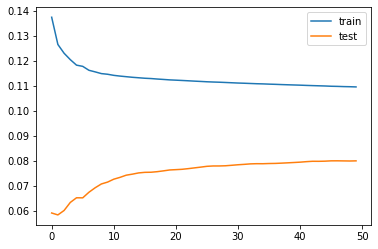

In [94]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()